## Dask Delayed
Dask Delayed is a feature in the `Dask` library that helps you build a **task graph** for computations involving Python functions. Instead of executing computations immediately, Dask Delayed delays the execution of your functions, allowing you to define a computational workflow first and then execute it efficiently in parallel.

It is particularly useful when working with computations that:

- Involve complex dependencies.
- Benefit from parallel execution.


To demomstrate this we consider a normal worksflow and a workflow using dask delayed 


In [1]:
import pandas as pd
import glob

In [2]:
#normal workflow
from time import sleep

def inc(x):
    sleep(1) 
    return x + 1

def add(x,y):
    sleep(1)
    return x + y



In [3]:
%%time
a = inc(1)
b = inc(2)
c = inc(3)
d = add(a, b)
e = add(d, c)

CPU times: user 598 μs, sys: 919 μs, total: 1.52 ms
Wall time: 5.01 s


The execution cost around 5 seconds (a second for everytime sleep is called). Nothing is run in parallel. 

To use the functionality of dask delayed functions you use the `@dask.delayed` decorator to wrap functions or computations. This transforms the function into a **lazy, delayed** task

In [4]:
from time import sleep
from dask import delayed

@delayed
def inc(x):
    sleep(1) 
    return x + 1

@delayed
def add(x,y):
    sleep(1)
    return x + y

Delayed functions create a task graph, which defines the sequence and dependencies of computations without executing them immediately. You can vixualize this with the `vizualize()`, Once the graph is fully defined, you execute it using the `.compute()` method, which triggers the parallel computation.

CPU times: user 6.33 ms, sys: 5.94 ms, total: 12.3 ms
Wall time: 103 ms


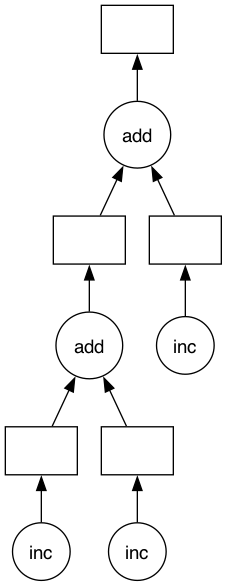

In [5]:
%%time

a = inc(1)
b = inc(2)
c = inc(3)
d = add(a, b)
e = add(d, c)
e.visualize()

In [6]:
%%time

a = inc(1)
b = inc(2)
c = inc(3)
d = add(a, b)
e = add(d, c)
e.compute()

CPU times: user 97.9 ms, sys: 17.4 ms, total: 115 ms
Wall time: 3.16 s


9

The execution time is now only three seconds. The first two `inc()` can be done in parallel (takes 1 second). The `inc()` and `add()` can be done in parallel (takes 1 second), and that result needs to be added with `add()` (takes 1 second). 

## Key features
- Flexible: Wrap any Python function. (you can either use `@delayed` decorator in combination with any python function or wrap delayed around the function without wrapper `delayed(inc(2))`)
- Visualize Task Graphs: You can visualize the task graph to understand dependencies using .visualize().
- Integration: Works seamlessly with other parts of Dask, like Dask Arrays, DataFrames.

## Using real world example

Suppose I have several files I want to process in parallel. I can use delayed functions to process in parallel. Since I run everything in parallel my results are a list of means. Top use `visualize()` I have to unpack the list with `*results`


In [7]:

#Normal implementation without dask

def read_file(filename):
    return pd.read_csv(filename, sep='\t')

def process_data(df):
    return df[df['TPSA'] > 100]  # Filter rows

def compute_statistics(df):
    return df['TPSA'].mean()   # Compute mean

df = read_file('data/mol_features_aa')
df.head()


,Name,Molecular Formula,Canonical SMILES,Molecular Weight,Heavy Atoms,LogP,Refractivity,TPSA,Fraction CSP3,H-Bond Donors,H-Bond Acceptors,Rotatable Bonds,Num Rings,Aromatic Rings,Aliphatic Rings,Stereo Centers,Charge,Valence Electrons
0,Esorubicin,C27H29NO10,COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@@](O)(C(=O)...,527.526,38,1.0305,130.3646,185.84,0.444444,5,11,5,5,2,3,5,0,202
1,MAYTANSINE,C34H46ClN3O10,COC1=CC2=CC(=C1Cl)N(C)C(=O)C[C@H](OC(=O)[C@H](...,692.206,48,3.5344,176.6285,156.47,0.588235,2,10,5,4,1,3,8,0,264
2,Talotrexin,C27H27N9O6,NC1=NC(N)=C2N=C(CNC3=CC=C(C(=O)N[C@@H](CCCNC(=...,573.570,42,1.2877,151.5800,248.43,0.185185,7,11,12,4,4,0,1,0,216
3,CEFUROXIME SODIUM,C16H15N4NaO8S,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(COC...,446.373,30,-4.8667,94.8451,176.59,0.312500,2,10,7,3,1,2,2,0,154
4,Cefquinome,C23H24N6O5S2,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,528.616,36,-0.6538,130.4071,153.92,0.391304,2,10,7,5,2,3,2,0,188


In [8]:
%%time
# Use glob to find matching files
filenames = glob.glob('data/mol_features_*')  # Matches all files with prefix "mol_features_" in "data" folder
results = [compute_statistics(process_data(read_file(f))) for f in filenames]
results

CPU times: user 25.4 ms, sys: 4.7 ms, total: 30.1 ms
Wall time: 30.8 ms


[np.float64(181.5858630952381),
 np.float64(188.54322020520914),
 np.float64(188.47529411764705)]

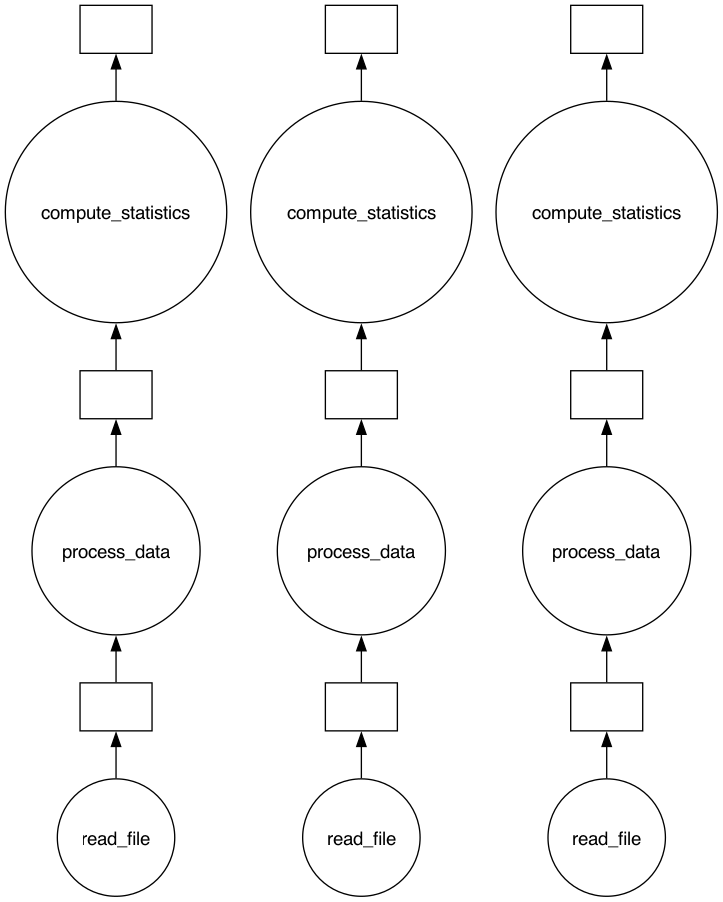

In [9]:
import dask
from dask import delayed
import pandas as pd

@delayed
def read_file(filename):
    return pd.read_csv(filename, sep='\t')

@delayed
def process_data(df):
    return df[df['TPSA'] > 100]  # Filter rows

@delayed
def compute_statistics(df):
    return df['TPSA'].mean()   # Compute mean

# Use glob to find matching files
filenames = glob.glob('data/mol_features_*')  # Matches all files with prefix "mol_features_" in "data" folder
results = [compute_statistics(process_data(read_file(f))) for f in filenames]

dask.visualize(*results)


In [10]:
%%time
# Delayed tasks for multiple files
filenames = glob.glob('data/mol_features_*')  # Matches all files with prefix "mol_features_" in "data" folder
results = [compute_statistics(process_data(read_file(f))) for f in filenames]
dask.compute(*results)

CPU times: user 22.8 ms, sys: 7.54 ms, total: 30.3 ms
Wall time: 22.6 ms


(np.float64(181.5858630952381),
 np.float64(188.54322020520914),
 np.float64(188.47529411764705))

## Dask DataFrame

A **Dask DataFrame** is a parallel, distributed version of a Pandas DataFrame. It allows you to work with datasets that are larger than memory by splitting the data into chunks and processing those chunks in parallel.

Dask DataFrame mimics the Pandas API, so most Pandas operations (like filtering, grouping, and aggregation) can be applied to Dask DataFrames with minimal changes to your code.


### **How Does it Work?**

1. **Chunking**:
   - A Dask DataFrame consists of multiple smaller Pandas DataFrames (called "partitions").
   - Each partition is a Pandas DataFrame, and operations are applied to each partition separately.

2. **Lazy Evaluation**:
   - Operations on a Dask DataFrame are not executed immediately. Instead, they build a **task graph** of computations.
   - Computation is only triggered when you explicitly call `.compute()`.

3. **Parallelism**:
   - Dask executes operations across partitions in parallel, using multiple CPU cores or even distributed clusters.


### **Dask vs. Pandas**

| Feature                | **Pandas**                            | **Dask DataFrame**                |
|------------------------|----------------------------------------|------------------------------------|
| **Dataset Size**       | Fits into memory                      | Larger-than-memory datasets       |
| **Execution**          | Immediate                             | Lazy (compute only when needed)   |
| **Parallelism**        | Single-threaded                       | Multi-threaded / distributed      |
| **Use Case**           | Small to medium datasets              | Large datasets or parallelism     |



### **Advantages**

1. **Handles Large Data**:
   - Works with datasets much larger than memory by processing chunks independently.

2. **Scales Seamlessly**:
   - Can run on a single machine or a distributed cluster without changes to the code.

3. **Parallel Execution**:
   - Automatically parallelizes operations across partitions.

4. **Minimal Code Changes**:
   - Uses a familiar Pandas-like API.



### **Limitations**

1. **Subset of Pandas API**:
   - Some complex operations, like custom functions or advanced indexing, may not be supported.

2. **Lazy Evaluation**:
   - Can make debugging harder because operations don't execute until `.compute()` is called.

3. **Overhead**:
   - For very small datasets, Dask can be slower than Pandas due to task graph creation and partitioning.



### **Key Functions**

- **`dd.read_csv()`**: Load large CSV files as a Dask DataFrame.
- **`dd.from_pandas()`**: Convert a Pandas DataFrame to a Dask DataFrame.
- **`to_csv()`**: Save a Dask DataFrame to CSV.
- **`compute()`**: Trigger computation and return results.



Dask DataFrames are a powerful tool for handling large datasets and parallelizing computations. They provide a familiar API for those experienced with Pandas while offering scalability and efficiency for big data workflows.

In [11]:
import dask.dataframe as dd

# Use Dask DataFrame directly combining all the files
df = dd.read_csv('data/mol_features_*', sep='\t')
filtered_df = df[df['TPSA'] > 100]
mean_tpsa = filtered_df['TPSA'].mean()
#mean_tpsa.visualize()
# Trigger computation
result = mean_tpsa.compute()
print(result)

185.7163969924812


In [12]:
df = dd.read_csv('data/mol_features_*', sep='\t')
df

,Name,Molecular Formula,Canonical SMILES,Molecular Weight,Heavy Atoms,LogP,Refractivity,TPSA,Fraction CSP3,H-Bond Donors,H-Bond Acceptors,Rotatable Bonds,Num Rings,Aromatic Rings,Aliphatic Rings,Stereo Centers,Charge,Valence Electrons
npartitions=3,,,,,,,,,,,,,,,,,,
,string,string,string,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
filtered_df = df[df['TPSA'] > 100]
filtered_df

,Name,Molecular Formula,Canonical SMILES,Molecular Weight,Heavy Atoms,LogP,Refractivity,TPSA,Fraction CSP3,H-Bond Donors,H-Bond Acceptors,Rotatable Bonds,Num Rings,Aromatic Rings,Aliphatic Rings,Stereo Centers,Charge,Valence Electrons
npartitions=3,,,,,,,,,,,,,,,,,,
,string,string,string,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


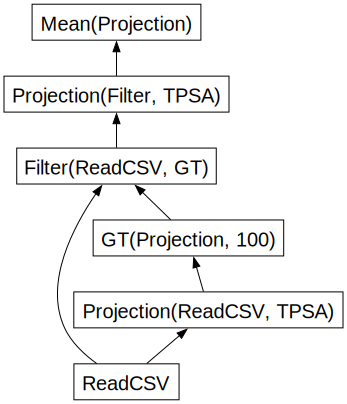

In [14]:
mean_tpsa = filtered_df['TPSA'].mean()
mean_tpsa.visualize()

When you visualize `mean_tpsa` and see nodes labeled with **GT** and **projection** and **mean**. Dask breaks down computations into smaller tasks to allow for efficient parallel execution. By separating operations **like Greater Than filtering** (`GT`) and **column selection** (`projection`), it ensures each step can be independently optimized and executed across chunks of data.

For example, the code:

```python
df[df['TPSA'] > 100]
```

is translated into a task in the graph as `GT`. It evaluates the condition for each row in the `TPSA` column.

The **projection** node represents the operation where a subset of columns or rows is extracted from a DataFrame. In the code:

```python
df['TPSA']
```

This selects the `'TPSA'` column from the DataFrame. Internally, Dask sees this as a "projection" because it's taking a subset (a single column) of the larger DataFrame.




In [15]:
%%time
# Use Dask DataFrame directly combining all the files
df = dd.read_csv('data/mol_features_*', sep='\t')
filtered_df = df[df['TPSA'] > 100]
mean_tpsa = filtered_df['TPSA'].mean()
#mean_tpsa.visualize()
# Trigger computation
result = mean_tpsa.compute()
print(result)

185.7163969924812
CPU times: user 16.3 ms, sys: 7.44 ms, total: 23.7 ms
Wall time: 17.8 ms


In [16]:
%%time
# Use Dask DataFrame directly combining all the files
df = dd.read_csv('data/all/mol_features_*', sep='\t')
filtered_df = df[df['TPSA'] > 100]
mean_tpsa = filtered_df['TPSA'].mean()
#mean_tpsa.visualize()
# Trigger computation
result = mean_tpsa.compute()
print(result)

191.99357672480755
CPU times: user 451 ms, sys: 171 ms, total: 622 ms
Wall time: 300 ms


In [17]:
%%time

filtered_df.head()

CPU times: user 34 ms, sys: 7.9 ms, total: 41.9 ms
Wall time: 71.6 ms


,Name,Molecular Formula,Canonical SMILES,Molecular Weight,Heavy Atoms,LogP,Refractivity,TPSA,Fraction CSP3,H-Bond Donors,H-Bond Acceptors,Rotatable Bonds,Num Rings,Aromatic Rings,Aliphatic Rings,Stereo Centers,Charge,Valence Electrons
0,Esorubicin,C27H29NO10,COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@@](O)(C(=O)...,527.526,38,1.0305,130.3646,185.84,0.444444,5,11,5,5,2,3,5,0,202
1,MAYTANSINE,C34H46ClN3O10,COC1=CC2=CC(=C1Cl)N(C)C(=O)C[C@H](OC(=O)[C@H](...,692.206,48,3.5344,176.6285,156.47,0.588235,2,10,5,4,1,3,8,0,264
2,Talotrexin,C27H27N9O6,NC1=NC(N)=C2N=C(CNC3=CC=C(C(=O)N[C@@H](CCCNC(=...,573.570,42,1.2877,151.5800,248.43,0.185185,7,11,12,4,4,0,1,0,216
3,CEFUROXIME SODIUM,C16H15N4NaO8S,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(COC...,446.373,30,-4.8667,94.8451,176.59,0.312500,2,10,7,3,1,2,2,0,154
4,Cefquinome,C23H24N6O5S2,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,528.616,36,-0.6538,130.4071,153.92,0.391304,2,10,7,5,2,3,2,0,188


In [18]:
%%time 

# Use glob to find all matching files
file_pattern = 'data/all/mol_features_*'
file_list = glob.glob(file_pattern)

# Read and combine all the files into a single Pandas DataFrame
df_list = [pd.read_csv(file, sep='\t') for file in file_list]
df = pd.concat(df_list, ignore_index=True)

# Filter rows where TPSA > 100
filtered_df = df[df['TPSA'] > 100]

# Calculate the mean of TPSA for filtered rows
mean_tpsa = filtered_df['TPSA'].mean()

# Print the result
print(mean_tpsa)


191.9935767248076
CPU times: user 815 ms, sys: 126 ms, total: 941 ms
Wall time: 943 ms


In [19]:
%%time

filtered_df.head()

CPU times: user 67 μs, sys: 5 μs, total: 72 μs
Wall time: 73.9 μs


,Name,Molecular Formula,Canonical SMILES,Molecular Weight,Heavy Atoms,LogP,Refractivity,TPSA,Fraction CSP3,H-Bond Donors,H-Bond Acceptors,Rotatable Bonds,Num Rings,Aromatic Rings,Aliphatic Rings,Stereo Centers,Charge,Valence Electrons
1,"(1'R,2'S,4S,5S,15'R,17'S,18'R)-2-amino-5-[(3-c...",[C39H58N3O3S2]+,C[C@]12CCSSC[C@@]3(CCCC4=C5CC1C[C@H](CO)[C@@H]...,681.045,47,5.26860,194.0364,109.55,0.743590,5,7,7,7,1,6,7,1,258
18,Oprea1_410410,C12H16N2O6,CC1=CC=C(N[C@@H]2OC[C@@H](O)[C@@H](O)[C@@H]2O)...,284.268,20,-0.24588,69.2165,125.09,0.500000,4,7,3,2,1,1,4,0,110
19,UNPD96421,C20H29NO8,C/C=C1/C[C@@H](C)[C@@](C)(OC(C)=O)C(=O)OC[C@@H...,411.451,29,0.82690,99.8112,122.19,0.750000,1,8,1,3,0,3,7,0,162
44,Asterriquinol G,C36H42N2O6,C=CC(C)(C)C1=C(C2=C(OC)C(O)=C(C3=CNC4=C(CC(OC)...,598.740,44,7.50660,176.3700,108.96,0.333333,4,6,11,5,5,0,1,0,232
45,Clostyrylpyrone C,C16H10O7,C=C1OC(=O)C2=C(C=CC3=CC(O)=C(O)C(O)=C3)OC(=O)C...,314.249,23,2.06810,79.7919,117.20,0.000000,3,7,2,3,2,1,0,0,116
